# Unsupervised Timeseries Representations
## Goal
Explore the extent of representation transferability allowed
by the algorithm described in [Unsupervised Scalable Representation Learning for Multivariate Time Series](https://arxiv.org/abs/1901.10738).

* Compare the transferability of representations learned using TimeNet and the convolutional architecture.
* Measure info change as output sequence length decreases, compare to principal components
* Introduce measure/standard testing procedure for transferability
* Rate corpus datasets by acc/(factor accntg. for dataset instances, dataset length, dataset classes)
* Do datasets with more classes work better as corpus sets?

## Method
1. Divide UCR timeseries dataset
    * Subset for learning representations
    * Subset for SVM classification
2. Train encoder network(s) on dataset to learn representations
3. Generate representations for classification dataset
4. Train and test SVM on classification dataset representations
   * Test on representation dataset
   * Test on different dataset
5. Compare with TimeNet if time

The dataset curation method is the focus of this research. We will test the transferability of
representations learned from two independent variables:
* dataset size
* dataset diversity

### Background
Info to include:
* Timeseries intro
* UCR dataset
* Concept and benefits of representations
* Encoder architecture
* Transfer ability
* What algo devs did to test transferability and how this extends that

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# !pip install uea_ucr_datasets sktime matrixprofile torch==0.4.1 numpy==1.15.2 pandas==0.23.4 scikit-learn==0.20.0 scipy==1.1.0
!pip install uea_ucr_datasets sktime matrixprofile

     |████████████████████████████████| 5.6MB 11.7MB/s 
     |████████████████████████████████| 849kB 48.9MB/s 
     |████████████████████████████████| 6.8MB 50.6MB/s 
     |████████████████████████████████| 9.5MB 46.4MB/s 
     |████████████████████████████████| 1.3MB 50.0MB/s 
ERROR: uea-ucr-datasets 0.1.2 has requirement sktime<0.4,>=0.3, but you'll have sktime 0.4.3 which is incompatible.
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


In [6]:
# Imports
import pandas as pd
import numpy as np
import matrixprofile as mp
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras import layers, models
from keras.utils import Sequence
import keras.backend as K
import tensorflow as tf
import tensorflow_addons as tfa
import sktime
import time
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from functools import partial
import os

import sys

drive_base = '/content/drive/My Drive'
sys.path.insert(1, os.path.join(drive_base, 'UnsupervisedScalableRepresentationLearningTimeSeries/'))
sys.path.insert(1, os.path.join(drive_base, 'TimeNet/'))

from scikit_wrappers import CausalCNNEncoderClassifier
from timenet import TimeNet, SimpleSeriesGenerator

In [7]:
# Load data
os.environ['UEA_UCR_DATA_DIR'] = os.path.join(drive_base, '.data/UEA_UCR')
import uea_ucr_datasets as archive

catalog= archive.list_datasets()

def standardize(X):
    mean = np.nanmean(X)
    std = np.sqrt(np.nanvar(X))

    for sample in X:
        sample = (sample - mean) / std

    return X

def get_dataset(name):
  d_train = archive.Dataset(name)
  d_test = archive.Dataset(name, train=False)

  max_train_len = max(map(lambda t: t[0].shape[0], d_train))
  max_test_len = max(map(lambda t: t[0].shape[0], d_test))
  max_len = max(max_train_len, max_test_len)

  X_train = np.array(list(map(lambda t: pad_array(t[0], max_len), d_train)))
  y_train = np.array(list(map(lambda t: t[1], d_train)))

  X_test = np.array(list(map(lambda t: pad_array(t[0], max_len), d_test)))
  y_test = np.array(list(map(lambda t: t[1], d_test)))

  X = np.concatenate([X_train, X_test])
  y = np.concatenate([y_train, y_test])

  try:
    X = standardize(X)
  except:
    print('Failed on', name)

  X = X.swapaxes(1, 2)

  labels = np.unique(y)
  transform = {}
  for i, l in enumerate(labels):
    transform[l] = i
  y = np.vectorize(lambda l: transform[l])(y)

  return X, y

def pad_array(x, length):
  assert x.ndim == 2
  assert x.shape[1] == 1
  
  if len(x) == length:
    return x

  x_padded = np.empty((length, 1))
  x[:] = 0
  x_padded[:len(x)] = x

  return x_padded

def pad_matrix(X, length):
  assert X.ndim == 3
  assert X.shape[1] == 1

  if X.shape[2] == length:
    return X
  
  X_padded = np.empty((X.shape[0], 1, length))
  X_padded[:] = 0
  for i in range(X.shape[0]):
    X_padded[i, :, :X.shape[2]] = X[i]
  return X_padded

  # return keras.preprocessing.sequence.pad_sequences(X[:, 0, :], value=0, dtype='float32', padding='post', maxlen=length)[:, np.newaxis, :]

def build_sampled_dataset(name, size=100):
  X, y = get_dataset(name)
  sample_idx = np.random.choice(X.shape[0], size=size)
  samples = X[sample_idx]
  sample_labels = y[sample_idx]

  assert len(samples) == size

  return samples, sample_labels

def build_mixed_dataset(size=1000, diversity=5):
  # sample_labels only meaningful when diversity==1

  samples_per_dataset = size // diversity
  remainder = size % diversity

  dataset_names = list(map(lambda i: catalog[i], np.random.choice(len(catalog), size=diversity, replace=False)))
  datasets = {}
  for d_name in dataset_names:
    datasets[d_name] = build_sampled_dataset(d_name, size=samples_per_dataset)

  max_len = max([d[0].shape[2] for d in datasets.values()])

  for name in datasets.keys():
    datasets[name] = pad_matrix(datasets[name][0], max_len), datasets[name][1]

  samples = np.concatenate(list(map(lambda d: d[0], list(datasets.values()))))
  sample_labels = np.concatenate(list(map(lambda d: d[1], list(datasets.values()))))

  if remainder:
    X_rem, y_rem = build_sampled_dataset(dataset_names[0], size=remainder)
    X_rem = pad_matrix(X_rem, max_len)

    samples = np.concatenate([samples, X_rem])
    sample_labels = np.concatenate([sample_labels, y_rem])

  assert len(samples) == size
  assert len(sample_labels) == size

  return samples, sample_labels, dataset_names

In [8]:
# Varying size
sample_sizes = [50, 100, 500, 1000]
dataset_names = ['ElectricDevices', 'EthanolLevel', 'Phoneme', 'ECG5000', 'Earthquakes']

metric_functions = [metrics.accuracy_score]
metric_functions.append(partial(metrics.precision_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.recall_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.f1_score, average='weighted'))

metric_names = ['accuracy', 'precision', 'recall', 'f1']

metric_dict = dict(zip(metric_names, metric_functions))

results_df = pd.DataFrame(columns=['train_dataset', 'test_dataset', 'samples', 'train_time'] + metric_names)

for dataset_name in dataset_names:
  for size in sample_sizes:
    X, y = build_sampled_dataset(dataset_name, size)

    # Train encoder
    cnn_encoder = CausalCNNEncoderClassifier(nb_random_samples=5,
                                             depth=10,
                                             channels=40,
                                             out_channels=160,
                                             reduced_size=320,
                                             nb_steps=1500,
                                             batch_size=16,
                                             kernel_size=3,
                                             early_stopping=3,
                                             cuda=True)
    
    start = time.time()
    cnn_encoder.fit(X, y)
    end = time.time()

    train_time = end - start

    cnn_encoder.save_encoder(os.path.join(drive_base, f'TDM/models/{dataset_name}-{size}'))

    # Test
    cls = cnn_encoder.classifier
    
    for d_name in dataset_names:
      results = {m_name: [] for m_name in metric_names}
      results['train_dataset'] = dataset_name
      results['test_dataset'] = d_name
      results['samples'] = size
      results['train_time'] = train_time

      X_full, y_full = get_dataset(d_name)
      representations = cnn_encoder.encode(X_full)

      cv = StratifiedKFold(n_splits=3)
      for train_split, test_split in cv.split(representations, y_full):
        X_train, y_train = representations[train_split], y_full[train_split]
        X_test, y_test = representations[test_split], y_full[test_split]

        cls.fit(X_train, y_train)
        pred = cls.predict(X_test)

        for m_name, f in metric_dict.items():
          results[m_name].append(f(y_test, pred))
      
      for m_name in metric_names:
        results[m_name] = np.mean(results[m_name])

      print('Results:')
      print(results)

      results_df = results_df.append(results, ignore_index=True)
      results_df.to_csv(os.path.join(drive_base, 'TDM/cnn_encoder_varied_size.csv'))

KeyboardInterrupt: ignored

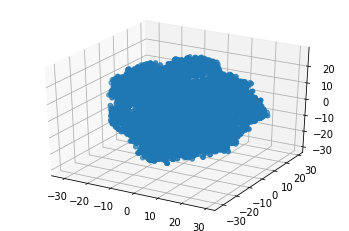

In [ ]:
# t-SNE
# tsne_encoder = CausalCNNEncoderClassifier(nb_random_samples=5,
#                                              depth=10,
#                                              channels=40,
#                                              out_channels=160,
#                                              reduced_size=320,
#                                              nb_steps=1500,
#                                              batch_size=16,
#                                              kernel_size=3,
#                                              early_stopping=3,
#                                              cuda=True)
tsne_encoder.load_encoder(os.path.join(drive_base, f'TDM/models/ElectricDevices-1000'))

X, _ = get_dataset('ChlorineConcentration')
encodings = tsne_encoder.encode(X)

tsne = TSNE(n_components=3).fit_transform(X[:, 0, :])

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*zip(*tsne))
plt.show()

In [ ]:
# Varied diversity
test_set_names = ['ElectricDevices', 'EthanolLevel', 'Phoneme', 'ECG5000', 'Earthquakes']
# diversities = [1, 3, 5, 10, 20, 40]
diversities = [40]
# diversities = [1, 3, 10, 20, 40]
samples = 500
# reps = 3
reps = 1

metric_functions = [metrics.accuracy_score]
metric_functions.append(partial(metrics.precision_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.recall_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.f1_score, average='weighted'))

metric_names = ['accuracy', 'precision', 'recall', 'f1']

metric_dict = dict(zip(metric_names, metric_functions))

# results_diversity_df = pd.DataFrame(columns=['diversity', 'samples', 'train_time', 'test_dataset'] + metric_names)
results_diversity_df = pd.read_csv(os.path.join(drive_base, 'TDM/cnn_encoder_diversity.csv'))

for diversity in diversities:
  print(f'Starting diversity {diversity}...')
  for rep in range(reps):
    print('Rep', rep)
    # try:
    X, _, _ = build_mixed_dataset(samples, diversity=diversity)
    print('Got dataset')

    # Train encoder
    cnn_encoder = CausalCNNEncoderClassifier(nb_random_samples=5,
                                            depth=10,
                                            channels=40,
                                            out_channels=160,
                                            reduced_size=320,
                                            nb_steps=1500,
                                            batch_size=16,
                                            kernel_size=3,
                                            cuda=True)
    
    start = time.time()
    cnn_encoder.fit_encoder(X)
    end = time.time()

    print('Model training finished')

    train_time = end - start

    cnn_encoder.save_encoder(os.path.join(drive_base, f'TDM/models/{diversity}-{samples}'))

    # Test
    cls = SVC()

    print('Testing...')
    for d_name in test_set_names:
      results = {m_name: [] for m_name in metric_names}
      results['test_dataset'] = d_name
      results['diversity'] = diversity
      results['samples'] = samples
      results['train_time'] = train_time

      X_full, y_full = get_dataset(d_name)
      representations = np.nan_to_num(cnn_encoder.encode(X_full))

      cv = StratifiedKFold(n_splits=3)
      for train_split, test_split in cv.split(representations, y_full):
        X_train, y_train = representations[train_split], y_full[train_split]
        X_test, y_test = representations[test_split], y_full[test_split]

        cls.fit(X_train, y_train)
        pred = cls.predict(X_test)

        for m_name, f in metric_dict.items():
          results[m_name].append(f(y_test, pred))
  
      for m_name in metric_names:
        results[m_name] = np.mean(results[m_name])

      print('Results:')
      print(results)

      results_diversity_df = results_diversity_df.append(results, ignore_index=True)
      results_diversity_df.to_csv(os.path.join(drive_base, 'TDM/cnn_encoder_diversity.csv'))
    # except Exception as e:
    #   print(e)

Starting diversity 40...
Rep 0


/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Got dataset
Model training finished
Testing...
Results:
{'accuracy': 0.25695738600058465, 'precision': 0.8090697126968182, 'recall': 0.25695738600058465, 'f1': 0.10505861098814284, 'test_dataset': 'ElectricDevices', 'diversity': 40, 'samples': 500, 'train_time': 1864.532517671585}
Results:
{'accuracy': 0.25099651443381893, 'precision': 0.8120028610700052, 'recall': 0.25099651443381893, 'f1': 0.10071863437631083, 'test_dataset': 'EthanolLevel', 'diversity': 40, 'samples': 500, 'train_time': 1864.532517671585}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.1127958101642312, 'precision': 0.8999274378914438, 'recall': 0.1127958101642312, 'f1': 0.022867052240357625, 'test_dataset': 'Phoneme', 'diversity': 40, 'samples': 500, 'train_time': 1864.532517671585}
Results:
{'accuracy': 0.5838000467133465, 'precision': 0.7570224751058682, 'recall': 0.5838000467133465, 'f1': 0.43038577517789184, 'test_dataset': 'ECG5000', 'diversity': 40, 'samples': 500, 'train_time': 1864.532517671585}
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 40, 'samples': 500, 'train_time': 1864.532517671585}


In [ ]:
# DTW 1NN for these datasets, SVM
# Add dataset ts len and encoding len to csv

In [ ]:
# TimeNet varying size
sample_sizes = [50, 100, 500, 1000]
dataset_names = ['ElectricDevices', 'EthanolLevel', 'Phoneme', 'ECG5000', 'Earthquakes']

metric_functions = [metrics.accuracy_score]
metric_functions.append(partial(metrics.precision_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.recall_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.f1_score, average='weighted'))

metric_names = ['accuracy', 'precision', 'recall', 'f1']

metric_dict = dict(zip(metric_names, metric_functions))

results_tn_df = pd.DataFrame(columns=['train_dataset', 'test_dataset', 'samples', 'train_time'] + metric_names)

for dataset_name in dataset_names:
  for size in sample_sizes:
    X, y = build_sampled_dataset(dataset_name, size)

    # Train encoder
    timenet = TimeNet(size=60, 
                      num_layers=3,
                      dropout=0.4,
                      batch_size=16)
    
    gen = SimpleSeriesGenerator(pd.DataFrame(X[:, 0, :]))

    start = time.time()
    timenet.train(gen, nb_epoch=1500*16//500, early_stop=3)
    end = time.time()

    train_time = end - start

    # Test
    cls = SVC()
    
    for d_name in dataset_names:
      results = {m_name: [] for m_name in metric_names}
      results['train_dataset'] = dataset_name
      results['test_dataset'] = d_name
      results['samples'] = size
      results['train_time'] = train_time

      X_full, y_full = get_dataset(d_name)
      t_gen = SimpleSeriesGenerator(pd.DataFrame(X_full[:, 0, :]))
      representations = timenet.encode(t_gen)

      cv = StratifiedKFold(n_splits=3)
      for train_split, test_split in cv.split(representations, y_full):
        X_train, y_train = representations[train_split], y_full[train_split]
        X_test, y_test = representations[test_split], y_full[test_split]

        cls.fit(X_train, y_train)
        pred = cls.predict(X_test)

        for m_name, f in metric_dict.items():
          results[m_name].append(f(y_test, pred))
      
      for m_name in metric_names:
        results[m_name] = np.mean(results[m_name])

      print('Results:')
      print(results)

      results_tn_df = results_df.append(results, ignore_index=True)
      results_tn_df.to_csv(os.path.join(drive_base, 'TDM/timenet_varied_size.csv'))

KeyboardInterrupt: ignored

In [ ]:
# Varied diversity
test_set_names = ['ElectricDevices', 'EthanolLevel', 'Phoneme', 'ECG5000', 'Earthquakes']
diversities = [1, 3, 5, 10, 20, 40]
samples = 500
val_size = 100
reps = 3

metric_functions = [metrics.accuracy_score]
metric_functions.append(partial(metrics.precision_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.recall_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.f1_score, average='weighted'))

metric_names = ['accuracy', 'precision', 'recall', 'f1']

metric_dict = dict(zip(metric_names, metric_functions))

results_tn_diversity_df = pd.DataFrame(columns=['diversity', 'samples', 'train_time', 'test_dataset'] + metric_names)

for diversity in diversities:
  for rep in range(reps):
    # try:
    X, _, _ = build_mixed_dataset(samples+val_size, diversity=diversity)
    val_set = X[:val_size]
    X = X[val_size:]

    # Train encoder
    timenet = TimeNet(size=60, 
                      num_layers=3,
                      dropout=0.2,
                      batch_size=16)
  
    gen = SimpleSeriesGenerator(pd.DataFrame(X[:, 0, :]))
    val_gen = SimpleSeriesGenerator(pd.DataFrame(val_set[:, 0, :]))
    
    start = time.time()
    timenet.train(gen, validation_data=val_gen, nb_epoch=1500*16//500, early_stop=3)
    end = time.time()

    train_time = end - start

    # Test
    cls = SVC()

    for d_name in test_set_names:
      results = {m_name: [] for m_name in metric_names}
      results['test_dataset'] = d_name
      results['diversity'] = diversity
      results['samples'] = samples
      results['train_time'] = train_time

      X_full, y_full = get_dataset(d_name)
      representations = np.nan_to_num(timenet.encode(pd.DataFrame(X_full[:, 0, :])))

      cv = StratifiedKFold(n_splits=3)
      for train_split, test_split in cv.split(representations, y_full):
        X_train, y_train = representations[train_split], y_full[train_split]
        X_test, y_test = representations[test_split], y_full[test_split]

        cls.fit(X_train, y_train)
        pred = cls.predict(X_test)

        for m_name, f in metric_dict.items():
          results[m_name].append(f(y_test, pred))
  
      for m_name in metric_names:
        results[m_name] = np.mean(results[m_name])

      print('Results:')
      print(results)

      results_tn_diversity_df = results_tn_diversity_df.append(results, ignore_index=True)
      results_tn_diversity_df.to_csv(os.path.join(drive_base, 'TDM/timenet_diversity.csv'))
    # except Exception as e:
    #   print(e)

(None, 180)
Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, None, 1)      0           main_input[0][0]                 
__________________________________________________________________________________________________
encode_1 (GRU)                  [(None, None, 60), ( 11340       main_input[0][0]                 
                                                                 lambda_5[0][0]                   
__________________________________________________________________________________________________
drop_encode_1 (Dropout)         (None, None, 60)     0           encode_1[

15/15 [==============================] - 16s 1s/step - loss: 425424.4688 - root_mean_squared_error: 652.2457 - mean_absolute_error: 576.4341 - mean_squared_logarithmic_error: 17.1219 - val_loss: 420568.9062 - val_root_mean_squared_error: 648.5128 - val_mean_absolute_error: 571.8186 - val_mean_squared_logarithmic_error: 12.2941
Epoch 2/48
15/15 [==============================] - 8s 552ms/step - loss: 414389.1250 - root_mean_squared_error: 643.7307 - mean_absolute_error: 566.7667 - mean_squared_logarithmic_error: 10.8097 - val_loss: 410344.8750 - val_root_mean_squared_error: 640.5817 - val_mean_absolute_error: 562.8076 - val_mean_squared_logarithmic_error: 9.4049
Epoch 3/48
15/15 [==============================] - 9s 569ms/step - loss: 403994.3438 - root_mean_squared_error: 635.6055 - mean_absolute_error: 557.6816 - mean_squared_logarithmic_error: 8.4991 - val_loss: 400150.0000 - val_root_mean_squared_error: 632.5741 - val_mean_absolute_error: 553.6763 - val_mean_squared_logarithmic_erro

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.12701382602698394, 'precision': 0.755720478459016, 'recall': 0.12701382602698394, 'f1': 0.0392656354382556, 'test_dataset': 'Phoneme', 'diversity': 1, 'samples': 500, 'train_time': 463.7826039791107}
157/157 [==============================] - 9s 56ms/step
Results:
{'accuracy': 0.9044025528627767, 'precision': 0.9101932186061328, 'recall': 0.9044025528627767, 'f1': 0.8748960840552917, 'test_dataset': 'ECG5000', 'diversity': 1, 'samples': 500, 'train_time': 463.7826039791107}
15/15 [==============================] - 2s 165ms/step
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 1, 'samples': 500, 'train_time': 463.7826039791107}


/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


(None, 180)
Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, None, 1)      0           main_input[0][0]                 
__________________________________________________________________________________________________
encode_1 (GRU)                  [(None, None, 60), ( 11340       main_input[0][0]                 
                                                                 lambda_6[0][0]                   
__________________________________________________________________________________________________
drop_encode_1 (Dropout)         (None, None, 60)     0           encode_1[

15/15 [==============================] - 36s 2s/step - loss: nan - root_mean_squared_error: nan - mean_absolute_error: nan - mean_squared_logarithmic_error: nan - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_squared_logarithmic_error: nan
Epoch 2/48
15/15 [==============================] - 22s 1s/step - loss: nan - root_mean_squared_error: nan - mean_absolute_error: nan - mean_squared_logarithmic_error: nan - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_squared_logarithmic_error: nan
Epoch 3/48
520/520 [==============================] - 21s 40ms/step
Results:
{'accuracy': 0.25695738600058465, 'precision': 0.8090697126968182, 'recall': 0.25695738600058465, 'f1': 0.10505861098814284, 'test_dataset': 'ElectricDevices', 'diversity': 1, 'samples': 500, 'train_time': 107.00446271896362}
32/32 [==============================] - 20s 621ms/step
Results:
{'accuracy': 0.25099651443381893, 'precision': 0.81

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.1127958101642312, 'precision': 0.8999274378914438, 'recall': 0.1127958101642312, 'f1': 0.022867052240357625, 'test_dataset': 'Phoneme', 'diversity': 1, 'samples': 500, 'train_time': 107.00446271896362}
157/157 [==============================] - 8s 54ms/step
Results:
{'accuracy': 0.5838000467133465, 'precision': 0.7570224751058682, 'recall': 0.5838000467133465, 'f1': 0.43038577517789184, 'test_dataset': 'ECG5000', 'diversity': 1, 'samples': 500, 'train_time': 107.00446271896362}
15/15 [==============================] - 2s 160ms/step
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 1, 'samples': 500, 'train_time': 107.00446271896362}


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


(None, 180)
Model: "functional_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, None, 1)      0           main_input[0][0]                 
__________________________________________________________________________________________________
encode_1 (GRU)                  [(None, None, 60), ( 11340       main_input[0][0]                 
                                                                 lambda_7[0][0]                   
__________________________________________________________________________________________________
drop_encode_1 (Dropout)         (None, None, 60)     0           encode_1[

15/15 [==============================] - 30s 2s/step - loss: nan - root_mean_squared_error: nan - mean_absolute_error: nan - mean_squared_logarithmic_error: nan - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_squared_logarithmic_error: nan
Epoch 2/48
15/15 [==============================] - 21s 1s/step - loss: nan - root_mean_squared_error: nan - mean_absolute_error: nan - mean_squared_logarithmic_error: nan - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_squared_logarithmic_error: nan
Epoch 3/48
520/520 [==============================] - 20s 39ms/step
Results:
{'accuracy': 0.25695738600058465, 'precision': 0.8090697126968182, 'recall': 0.25695738600058465, 'f1': 0.10505861098814284, 'test_dataset': 'ElectricDevices', 'diversity': 1, 'samples': 500, 'train_time': 99.09323167800903}
32/32 [==============================] - 19s 583ms/step
Results:
{'accuracy': 0.25099651443381893, 'precision': 0.812

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.1127958101642312, 'precision': 0.8999274378914438, 'recall': 0.1127958101642312, 'f1': 0.022867052240357625, 'test_dataset': 'Phoneme', 'diversity': 1, 'samples': 500, 'train_time': 99.09323167800903}
157/157 [==============================] - 9s 58ms/step
Results:
{'accuracy': 0.5838000467133465, 'precision': 0.7570224751058682, 'recall': 0.5838000467133465, 'f1': 0.43038577517789184, 'test_dataset': 'ECG5000', 'diversity': 1, 'samples': 500, 'train_time': 99.09323167800903}
15/15 [==============================] - 3s 176ms/step
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 1, 'samples': 500, 'train_time': 99.09323167800903}


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(None, 180)
Model: "functional_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, None, 1)      0           main_input[0][0]                 
__________________________________________________________________________________________________
encode_1 (GRU)                  [(None, None, 60), ( 11340       main_input[0][0]                 
                                                                 lambda_8[0][0]                   
__________________________________________________________________________________________________
drop_encode_1 (Dropout)         (None, None, 60)     0           encode_1[

15/15 [==============================] - 34s 2s/step - loss: nan - root_mean_squared_error: nan - mean_absolute_error: nan - mean_squared_logarithmic_error: nan - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_squared_logarithmic_error: nan
Epoch 2/48
15/15 [==============================] - 23s 2s/step - loss: nan - root_mean_squared_error: nan - mean_absolute_error: nan - mean_squared_logarithmic_error: nan - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_squared_logarithmic_error: nan
Epoch 3/48
520/520 [==============================] - 20s 39ms/step
Results:
{'accuracy': 0.25695738600058465, 'precision': 0.8090697126968182, 'recall': 0.25695738600058465, 'f1': 0.10505861098814284, 'test_dataset': 'ElectricDevices', 'diversity': 3, 'samples': 500, 'train_time': 104.65843272209167}
32/32 [==============================] - 18s 564ms/step
Results:
{'accuracy': 0.25099651443381893, 'precision': 0.81

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.1127958101642312, 'precision': 0.8999274378914438, 'recall': 0.1127958101642312, 'f1': 0.022867052240357625, 'test_dataset': 'Phoneme', 'diversity': 3, 'samples': 500, 'train_time': 104.65843272209167}
157/157 [==============================] - 9s 55ms/step
Results:
{'accuracy': 0.5838000467133465, 'precision': 0.7570224751058682, 'recall': 0.5838000467133465, 'f1': 0.43038577517789184, 'test_dataset': 'ECG5000', 'diversity': 3, 'samples': 500, 'train_time': 104.65843272209167}
15/15 [==============================] - 2s 165ms/step
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 3, 'samples': 500, 'train_time': 104.65843272209167}


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(None, 180)
Model: "functional_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, None, 1)      0           main_input[0][0]                 
__________________________________________________________________________________________________
encode_1 (GRU)                  [(None, None, 60), ( 11340       main_input[0][0]                 
                                                                 lambda_9[0][0]                   
__________________________________________________________________________________________________
drop_encode_1 (Dropout)         (None, None, 60)     0           encode_1[

15/15 [==============================] - 31s 2s/step - loss: nan - root_mean_squared_error: nan - mean_absolute_error: nan - mean_squared_logarithmic_error: nan - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_squared_logarithmic_error: nan
Epoch 2/48
15/15 [==============================] - 22s 1s/step - loss: nan - root_mean_squared_error: nan - mean_absolute_error: nan - mean_squared_logarithmic_error: nan - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_squared_logarithmic_error: nan
Epoch 3/48
520/520 [==============================] - 20s 39ms/step
Results:
{'accuracy': 0.25695738600058465, 'precision': 0.8090697126968182, 'recall': 0.25695738600058465, 'f1': 0.10505861098814284, 'test_dataset': 'ElectricDevices', 'diversity': 3, 'samples': 500, 'train_time': 102.56422972679138}
32/32 [==============================] - 18s 560ms/step
Results:
{'accuracy': 0.25099651443381893, 'precision': 0.81

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.1127958101642312, 'precision': 0.8999274378914438, 'recall': 0.1127958101642312, 'f1': 0.022867052240357625, 'test_dataset': 'Phoneme', 'diversity': 3, 'samples': 500, 'train_time': 102.56422972679138}
157/157 [==============================] - 9s 57ms/step
Results:
{'accuracy': 0.5838000467133465, 'precision': 0.7570224751058682, 'recall': 0.5838000467133465, 'f1': 0.43038577517789184, 'test_dataset': 'ECG5000', 'diversity': 3, 'samples': 500, 'train_time': 102.56422972679138}
15/15 [==============================] - 3s 167ms/step
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 3, 'samples': 500, 'train_time': 102.56422972679138}


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(None, 180)
Model: "functional_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, None, 1)      0           main_input[0][0]                 
__________________________________________________________________________________________________
encode_1 (GRU)                  [(None, None, 60), ( 11340       main_input[0][0]                 
                                                                 lambda_10[0][0]                  
__________________________________________________________________________________________________
drop_encode_1 (Dropout)         (None, None, 60)     0           encode_1[

15/15 [==============================] - 31s 2s/step - loss: nan - root_mean_squared_error: nan - mean_absolute_error: nan - mean_squared_logarithmic_error: nan - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_squared_logarithmic_error: nan
Epoch 2/48
15/15 [==============================] - 22s 1s/step - loss: nan - root_mean_squared_error: nan - mean_absolute_error: nan - mean_squared_logarithmic_error: nan - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_squared_logarithmic_error: nan
Epoch 3/48
520/520 [==============================] - 21s 40ms/step
Results:
{'accuracy': 0.25695738600058465, 'precision': 0.8090697126968182, 'recall': 0.25695738600058465, 'f1': 0.10505861098814284, 'test_dataset': 'ElectricDevices', 'diversity': 3, 'samples': 500, 'train_time': 99.0835280418396}
32/32 [==============================] - 20s 636ms/step
Results:
{'accuracy': 0.25099651443381893, 'precision': 0.8120

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.1127958101642312, 'precision': 0.8999274378914438, 'recall': 0.1127958101642312, 'f1': 0.022867052240357625, 'test_dataset': 'Phoneme', 'diversity': 3, 'samples': 500, 'train_time': 99.0835280418396}
157/157 [==============================] - 9s 58ms/step
Results:
{'accuracy': 0.5838000467133465, 'precision': 0.7570224751058682, 'recall': 0.5838000467133465, 'f1': 0.43038577517789184, 'test_dataset': 'ECG5000', 'diversity': 3, 'samples': 500, 'train_time': 99.0835280418396}
15/15 [==============================] - 2s 165ms/step
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 3, 'samples': 500, 'train_time': 99.0835280418396}


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(None, 180)
Model: "functional_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, None, 1)      0           main_input[0][0]                 
__________________________________________________________________________________________________
encode_1 (GRU)                  [(None, None, 60), ( 11340       main_input[0][0]                 
                                                                 lambda_11[0][0]                  
__________________________________________________________________________________________________
drop_encode_1 (Dropout)         (None, None, 60)     0           encode_1[

15/15 [==============================] - 39s 3s/step - loss: nan - root_mean_squared_error: nan - mean_absolute_error: nan - mean_squared_logarithmic_error: nan - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_squared_logarithmic_error: nan
Epoch 2/48
15/15 [==============================] - 29s 2s/step - loss: nan - root_mean_squared_error: nan - mean_absolute_error: nan - mean_squared_logarithmic_error: nan - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_squared_logarithmic_error: nan
Epoch 3/48
520/520 [==============================] - 20s 39ms/step
Results:
{'accuracy': 0.25695738600058465, 'precision': 0.8090697126968182, 'recall': 0.25695738600058465, 'f1': 0.10505861098814284, 'test_dataset': 'ElectricDevices', 'diversity': 5, 'samples': 500, 'train_time': 121.63353538513184}
32/32 [==============================] - 19s 580ms/step
Results:
{'accuracy': 0.25099651443381893, 'precision': 0.81

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.1127958101642312, 'precision': 0.8999274378914438, 'recall': 0.1127958101642312, 'f1': 0.022867052240357625, 'test_dataset': 'Phoneme', 'diversity': 5, 'samples': 500, 'train_time': 121.63353538513184}
157/157 [==============================] - 9s 58ms/step
Results:
{'accuracy': 0.5838000467133465, 'precision': 0.7570224751058682, 'recall': 0.5838000467133465, 'f1': 0.43038577517789184, 'test_dataset': 'ECG5000', 'diversity': 5, 'samples': 500, 'train_time': 121.63353538513184}
15/15 [==============================] - 3s 173ms/step
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 5, 'samples': 500, 'train_time': 121.63353538513184}


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(None, 180)
Model: "functional_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, None, 1)      0           main_input[0][0]                 
__________________________________________________________________________________________________
encode_1 (GRU)                  [(None, None, 60), ( 11340       main_input[0][0]                 
                                                                 lambda_12[0][0]                  
__________________________________________________________________________________________________
drop_encode_1 (Dropout)         (None, None, 60)     0           encode_1[

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.1127958101642312, 'precision': 0.8999274378914438, 'recall': 0.1127958101642312, 'f1': 0.022867052240357625, 'test_dataset': 'Phoneme', 'diversity': 5, 'samples': 500, 'train_time': 127.03376865386963}
157/157 [==============================] - 9s 57ms/step
Results:
{'accuracy': 0.5838000467133465, 'precision': 0.7570224751058682, 'recall': 0.5838000467133465, 'f1': 0.43038577517789184, 'test_dataset': 'ECG5000', 'diversity': 5, 'samples': 500, 'train_time': 127.03376865386963}
15/15 [==============================] - 3s 173ms/step
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 5, 'samples': 500, 'train_time': 127.03376865386963}


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(None, 180)
Model: "functional_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, None, 1)      0           main_input[0][0]                 
__________________________________________________________________________________________________
encode_1 (GRU)                  [(None, None, 60), ( 11340       main_input[0][0]                 
                                                                 lambda_13[0][0]                  
__________________________________________________________________________________________________
drop_encode_1 (Dropout)         (None, None, 60)     0           encode_1[

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.1127958101642312, 'precision': 0.8999274378914438, 'recall': 0.1127958101642312, 'f1': 0.022867052240357625, 'test_dataset': 'Phoneme', 'diversity': 5, 'samples': 500, 'train_time': 127.00402474403381}
157/157 [==============================] - 9s 59ms/step
Results:
{'accuracy': 0.5838000467133465, 'precision': 0.7570224751058682, 'recall': 0.5838000467133465, 'f1': 0.43038577517789184, 'test_dataset': 'ECG5000', 'diversity': 5, 'samples': 500, 'train_time': 127.00402474403381}
15/15 [==============================] - 3s 173ms/step
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 5, 'samples': 500, 'train_time': 127.00402474403381}


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(None, 180)
Model: "functional_59"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda_14 (Lambda)              (None, None, 1)      0           main_input[0][0]                 
__________________________________________________________________________________________________
encode_1 (GRU)                  [(None, None, 60), ( 11340       main_input[0][0]                 
                                                                 lambda_14[0][0]                  
__________________________________________________________________________________________________
drop_encode_1 (Dropout)         (None, None, 60)     0           encode_1[

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.1127958101642312, 'precision': 0.8999274378914438, 'recall': 0.1127958101642312, 'f1': 0.022867052240357625, 'test_dataset': 'Phoneme', 'diversity': 10, 'samples': 500, 'train_time': 336.78920102119446}
157/157 [==============================] - 9s 56ms/step
Results:
{'accuracy': 0.5838000467133465, 'precision': 0.7570224751058682, 'recall': 0.5838000467133465, 'f1': 0.43038577517789184, 'test_dataset': 'ECG5000', 'diversity': 10, 'samples': 500, 'train_time': 336.78920102119446}
15/15 [==============================] - 3s 169ms/step
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 10, 'samples': 500, 'train_time': 336.78920102119446}


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(None, 180)
Model: "functional_63"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda_15 (Lambda)              (None, None, 1)      0           main_input[0][0]                 
__________________________________________________________________________________________________
encode_1 (GRU)                  [(None, None, 60), ( 11340       main_input[0][0]                 
                                                                 lambda_15[0][0]                  
__________________________________________________________________________________________________
drop_encode_1 (Dropout)         (None, None, 60)     0           encode_1[

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.1127958101642312, 'precision': 0.8999274378914438, 'recall': 0.1127958101642312, 'f1': 0.022867052240357625, 'test_dataset': 'Phoneme', 'diversity': 10, 'samples': 500, 'train_time': 334.947242975235}
157/157 [==============================] - 9s 57ms/step
Results:
{'accuracy': 0.5838000467133465, 'precision': 0.7570224751058682, 'recall': 0.5838000467133465, 'f1': 0.43038577517789184, 'test_dataset': 'ECG5000', 'diversity': 10, 'samples': 500, 'train_time': 334.947242975235}
15/15 [==============================] - 3s 168ms/step
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 10, 'samples': 500, 'train_time': 334.947242975235}


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(None, 180)
Model: "functional_67"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda_16 (Lambda)              (None, None, 1)      0           main_input[0][0]                 
__________________________________________________________________________________________________
encode_1 (GRU)                  [(None, None, 60), ( 11340       main_input[0][0]                 
                                                                 lambda_16[0][0]                  
__________________________________________________________________________________________________
drop_encode_1 (Dropout)         (None, None, 60)     0           encode_1[

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.1127958101642312, 'precision': 0.8999274378914438, 'recall': 0.1127958101642312, 'f1': 0.022867052240357625, 'test_dataset': 'Phoneme', 'diversity': 10, 'samples': 500, 'train_time': 333.3497517108917}
157/157 [==============================] - 9s 56ms/step
Results:
{'accuracy': 0.5838000467133465, 'precision': 0.7570224751058682, 'recall': 0.5838000467133465, 'f1': 0.43038577517789184, 'test_dataset': 'ECG5000', 'diversity': 10, 'samples': 500, 'train_time': 333.3497517108917}
15/15 [==============================] - 3s 170ms/step
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 10, 'samples': 500, 'train_time': 333.3497517108917}


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(None, 180)
Model: "functional_71"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, None, 1)      0           main_input[0][0]                 
__________________________________________________________________________________________________
encode_1 (GRU)                  [(None, None, 60), ( 11340       main_input[0][0]                 
                                                                 lambda_17[0][0]                  
__________________________________________________________________________________________________
drop_encode_1 (Dropout)         (None, None, 60)     0           encode_1[

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.1127958101642312, 'precision': 0.8999274378914438, 'recall': 0.1127958101642312, 'f1': 0.022867052240357625, 'test_dataset': 'Phoneme', 'diversity': 20, 'samples': 500, 'train_time': 659.8550615310669}
157/157 [==============================] - 8s 54ms/step
Results:
{'accuracy': 0.5838000467133465, 'precision': 0.7570224751058682, 'recall': 0.5838000467133465, 'f1': 0.43038577517789184, 'test_dataset': 'ECG5000', 'diversity': 20, 'samples': 500, 'train_time': 659.8550615310669}
15/15 [==============================] - 2s 156ms/step
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 20, 'samples': 500, 'train_time': 659.8550615310669}


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(None, 180)
Model: "functional_75"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda_18 (Lambda)              (None, None, 1)      0           main_input[0][0]                 
__________________________________________________________________________________________________
encode_1 (GRU)                  [(None, None, 60), ( 11340       main_input[0][0]                 
                                                                 lambda_18[0][0]                  
__________________________________________________________________________________________________
drop_encode_1 (Dropout)         (None, None, 60)     0           encode_1[

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.1127958101642312, 'precision': 0.8999274378914438, 'recall': 0.1127958101642312, 'f1': 0.022867052240357625, 'test_dataset': 'Phoneme', 'diversity': 20, 'samples': 500, 'train_time': 660.0927205085754}
157/157 [==============================] - 9s 55ms/step
Results:
{'accuracy': 0.5838000467133465, 'precision': 0.7570224751058682, 'recall': 0.5838000467133465, 'f1': 0.43038577517789184, 'test_dataset': 'ECG5000', 'diversity': 20, 'samples': 500, 'train_time': 660.0927205085754}
15/15 [==============================] - 2s 158ms/step
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 20, 'samples': 500, 'train_time': 660.0927205085754}


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(None, 180)
Model: "functional_79"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda_19 (Lambda)              (None, None, 1)      0           main_input[0][0]                 
__________________________________________________________________________________________________
encode_1 (GRU)                  [(None, None, 60), ( 11340       main_input[0][0]                 
                                                                 lambda_19[0][0]                  
__________________________________________________________________________________________________
drop_encode_1 (Dropout)         (None, None, 60)     0           encode_1[

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.1127958101642312, 'precision': 0.8999274378914438, 'recall': 0.1127958101642312, 'f1': 0.022867052240357625, 'test_dataset': 'Phoneme', 'diversity': 20, 'samples': 500, 'train_time': 669.3379373550415}
157/157 [==============================] - 8s 54ms/step
Results:
{'accuracy': 0.5838000467133465, 'precision': 0.7570224751058682, 'recall': 0.5838000467133465, 'f1': 0.43038577517789184, 'test_dataset': 'ECG5000', 'diversity': 20, 'samples': 500, 'train_time': 669.3379373550415}
15/15 [==============================] - 2s 159ms/step
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 20, 'samples': 500, 'train_time': 669.3379373550415}


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(None, 180)
Model: "functional_83"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda_20 (Lambda)              (None, None, 1)      0           main_input[0][0]                 
__________________________________________________________________________________________________
encode_1 (GRU)                  [(None, None, 60), ( 11340       main_input[0][0]                 
                                                                 lambda_20[0][0]                  
__________________________________________________________________________________________________
drop_encode_1 (Dropout)         (None, None, 60)     0           encode_1[

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.1127958101642312, 'precision': 0.8999274378914438, 'recall': 0.1127958101642312, 'f1': 0.022867052240357625, 'test_dataset': 'Phoneme', 'diversity': 40, 'samples': 500, 'train_time': 663.6404182910919}
157/157 [==============================] - 8s 54ms/step
Results:
{'accuracy': 0.5838000467133465, 'precision': 0.7570224751058682, 'recall': 0.5838000467133465, 'f1': 0.43038577517789184, 'test_dataset': 'ECG5000', 'diversity': 40, 'samples': 500, 'train_time': 663.6404182910919}
15/15 [==============================] - 3s 167ms/step
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 40, 'samples': 500, 'train_time': 663.6404182910919}


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(None, 180)
Model: "functional_87"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda_21 (Lambda)              (None, None, 1)      0           main_input[0][0]                 
__________________________________________________________________________________________________
encode_1 (GRU)                  [(None, None, 60), ( 11340       main_input[0][0]                 
                                                                 lambda_21[0][0]                  
__________________________________________________________________________________________________
drop_encode_1 (Dropout)         (None, None, 60)     0           encode_1[

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.1127958101642312, 'precision': 0.8999274378914438, 'recall': 0.1127958101642312, 'f1': 0.022867052240357625, 'test_dataset': 'Phoneme', 'diversity': 40, 'samples': 500, 'train_time': 679.3206934928894}
157/157 [==============================] - 8s 54ms/step
Results:
{'accuracy': 0.5838000467133465, 'precision': 0.7570224751058682, 'recall': 0.5838000467133465, 'f1': 0.43038577517789184, 'test_dataset': 'ECG5000', 'diversity': 40, 'samples': 500, 'train_time': 679.3206934928894}
15/15 [==============================] - 2s 162ms/step
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 40, 'samples': 500, 'train_time': 679.3206934928894}


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(None, 180)
Model: "functional_91"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda_22 (Lambda)              (None, None, 1)      0           main_input[0][0]                 
__________________________________________________________________________________________________
encode_1 (GRU)                  [(None, None, 60), ( 11340       main_input[0][0]                 
                                                                 lambda_22[0][0]                  
__________________________________________________________________________________________________
drop_encode_1 (Dropout)         (None, None, 60)     0           encode_1[

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.1127958101642312, 'precision': 0.8999274378914438, 'recall': 0.1127958101642312, 'f1': 0.022867052240357625, 'test_dataset': 'Phoneme', 'diversity': 40, 'samples': 500, 'train_time': 668.3202192783356}
157/157 [==============================] - 8s 54ms/step
Results:
{'accuracy': 0.5838000467133465, 'precision': 0.7570224751058682, 'recall': 0.5838000467133465, 'f1': 0.43038577517789184, 'test_dataset': 'ECG5000', 'diversity': 40, 'samples': 500, 'train_time': 668.3202192783356}
15/15 [==============================] - 2s 161ms/step
Results:
{'accuracy': 0.79826273943921, 'precision': 0.8389610464062348, 'recall': 0.79826273943921, 'f1': 0.7087101413879923, 'test_dataset': 'Earthquakes', 'diversity': 40, 'samples': 500, 'train_time': 668.3202192783356}


In [ ]:
# # Compare models on large corpus
# # Build datasets
train_set_names = ['ShapesAll', 'Fish',
                   'ChlorineConcentration', 'ECG5000', 'FordA', 'Meat', 'ToeSegmentation2', 
                   'Lightning7', 'FreezerRegularTrain', 'ArrowHead', 'Adiac', 
                   'GunPointOldVersusYoung', 'MoteStrain', 'Wine', 'Yoga']

train_set = []
for name in train_set_names:
  X, _ = get_dataset(name)
  train_set.extend(X[:, 0, :])
train_set = np.array(train_set)
padded_train_set = keras.preprocessing.sequence.pad_sequences(train_set, 
                                                               dtype='float32',
                                                               padding='pre',
                                                               value=0.0)
np.random.shuffle(padded_train_set)
train_corpus = padded_train_set[:, np.newaxis, :]

all_set_names = archive.list_datasets()
test_set_names = [name for name in all_set_names if name not in train_set_names]

# Metrics
metric_functions = [metrics.accuracy_score]
metric_functions.append(partial(metrics.precision_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.recall_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.f1_score, average='weighted'))

metric_names = ['accuracy', 'precision', 'recall', 'f1']

metric_dict = dict(zip(metric_names, metric_functions))

big_cnn_results_df = pd.DataFrame(columns=['test_dataset', 'train_time'] + metric_names)

# Train encoder
cnn_encoder = CausalCNNEncoderClassifier(nb_random_samples=5,
                                        depth=10,
                                        channels=40,
                                        out_channels=160,
                                        reduced_size=320,
                                        nb_steps=3000,
                                        batch_size=32,
                                        kernel_size=3,
                                        early_stopping=3,
                                        cuda=True)

start = time.time()
cnn_encoder.fit_encoder(train_corpus, verbose=True)
end = time.time()

train_time = end - start

cnn_encoder.save_encoder(os.path.join(drive_base, f'TDM/models/holistic_cnn'))

# Test
cls = SVC()

# for name in test_set_names:
todo = [name for name in all_set_names if name not in big_cnn_results_df['test_dataset'].unique()]
for name in todo:
  results = {m_name: [] for m_name in metric_names}
  results['test_dataset'] = name
  results['train_time'] = train_time

  X_full, y_full = get_dataset(name)
  representations = cnn_encoder.encode(X_full)

  cv = StratifiedKFold(n_splits=3)
  for train_split, test_split in cv.split(representations, y_full):
    X_train, y_train = representations[train_split], y_full[train_split]
    X_test, y_test = representations[test_split], y_full[test_split]

    try:
      cls.fit(X_train, y_train)
      pred = cls.predict(X_test)
    except Exception as e:
      print('failed on', name)
      print(e)
      continue

    for m_name, f in metric_dict.items():
      results[m_name].append(f(y_test, pred))
  
  for m_name in metric_names:
    results[m_name] = np.mean(results[m_name])

  print('Results:')
  print(results)

  big_cnn_results_df = big_cnn_results_df.append(results, ignore_index=True)
  big_cnn_results_df.to_csv(os.path.join(drive_base, 'TDM/holistic_cnn_encoder_results.csv'))

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Results:
{'accuracy': 0.5294018508304222, 'precision': 0.6282479084502269, 'recall': 0.5294018508304222, 'f1': 0.47566200940861547, 'test_dataset': 'OSULeaf', 'train_time': 865.4357106685638}
Results:
{'accuracy': 0.7753983033312642, 'precision': 0.8518870302824734, 'recall': 0.7753983033312642, 'f1': 0.7486518331812912, 'test_dataset': 'DistalPhalanxOutlineAgeGroup', 'train_time': 865.4357106685638}
Results:
{'accuracy': 0.3779051432678415, 'precision': 0.6743109256944829, 'recall': 0.3779051432678415, 'f1': 0.25840654128196316, 'test_dataset': 'FiftyWords', 'train_time': 865.4357106685638}
Results:
{'accuracy': 0.6643320900676889, 'precision': 0.7108345328208342, 'recall': 0.6643320900676889, 'f1': 0.5751829305757777, 'test_dataset': 'MedicalImages', 'train_time': 865.4357106685638}
Results:
{'accuracy': 0.9829996785756894, 'precision': 0.9832648413266561, 'recall': 0.9829996785756894, 'f1': 0.9830232528003281, 'test_dataset': 'TwoPatterns', 't

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Results:
{'accuracy': 0.9500000000000001, 'precision': 0.9511932064007783, 'recall': 0.9500000000000001, 'f1': 0.9499060891007399, 'test_dataset': 'Symbols', 'train_time': 865.4357106685638}
Results:
{'accuracy': 0.7513656114214773, 'precision': 0.8516516349537314, 'recall': 0.7513656114214773, 'f1': 0.6759981265178944, 'test_dataset': 'DistalPhalanxTW', 'train_time': 865.4357106685638}
Results:
{'accuracy': 0.452855245683931, 'precision': 0.5846510055206364, 'recall': 0.452855245683931, 'f1': 0.4092590559638993, 'test_dataset': 'NonInvasiveFetalECGThorax1', 'train_time': 865.4357106685638}
Results:
{'accuracy': 0.4155555555555555, 'precision': 0.5019652648178526, 'recall': 0.4155555555555555, 'f1': 0.3930752109298899, 'test_dataset': 'SemgHandMovementCh2', 'train_time': 865.4357106685638}
Results:
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'test_dataset': 'InsectEPGRegularTrain', 'train_time': 865.4357106685638}
failed on AllGestureWiimoteY
Input contains NaN, infin

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Results:
{'accuracy': 0.21847587719298245, 'precision': 0.5017813647296873, 'recall': 0.21847587719298245, 'f1': 0.13713787478309164, 'test_dataset': 'Phoneme', 'train_time': 865.4357106685638}
Results:
{'accuracy': 0.5666666666666667, 'precision': 0.7800290733758475, 'recall': 0.5666666666666667, 'f1': 0.465734726720958, 'test_dataset': 'Meat', 'train_time': 865.4357106685638}
Results:
{'accuracy': 0.14423076923076925, 'precision': 0.5401149776149776, 'recall': 0.14423076923076925, 'f1': 0.10783568283568283, 'test_dataset': 'PigArtPressure', 'train_time': 865.4357106685638}
Results:
{'accuracy': 0.9452143303378514, 'precision': 0.9443831993361597, 'recall': 0.9452143303378514, 'f1': 0.9446283104272158, 'test_dataset': 'StarLightCurves', 'train_time': 865.4357106685638}


/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


failed on AllGestureWiimoteX
Input contains NaN, infinity or a value too large for dtype('float64').
failed on AllGestureWiimoteX
Input contains NaN, infinity or a value too large for dtype('float64').
failed on AllGestureWiimoteX
Input contains NaN, infinity or a value too large for dtype('float64').
Results:
{'accuracy': nan, 'precision': nan, 'recall': nan, 'f1': nan, 'test_dataset': 'AllGestureWiimoteX', 'train_time': 865.4357106685638}


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Results:
{'accuracy': 0.6477987421383647, 'precision': 0.7672893659002474, 'recall': 0.6477987421383647, 'f1': 0.573716339269083, 'test_dataset': 'HouseTwenty', 'train_time': 865.4357106685638}
Results:
{'accuracy': 0.9266666666666666, 'precision': 0.9307476523625717, 'recall': 0.9266666666666666, 'f1': 0.9265593351765838, 'test_dataset': 'SmoothSubspace', 'train_time': 865.4357106685638}
Results:
{'accuracy': 0.4115384615384616, 'precision': 0.4891298075478463, 'recall': 0.4115384615384616, 'f1': 0.3981411592597189, 'test_dataset': 'CricketY', 'train_time': 865.4357106685638}
Results:
{'accuracy': 0.43798449612403106, 'precision': 0.6797680464710129, 'recall': 0.43798449612403106, 'f1': 0.302300153117064, 'test_dataset': 'Worms', 'train_time': 865.4357106685638}
Results:
{'accuracy': 0.686117189399465, 'precision': 0.7606610519388868, 'recall': 0.686117189399465, 'f1': 0.6010503794086779, 'test_dataset': 'HandOutlines', 'train_time': 865.4357106685638}
Results:
{'accuracy': 0.85986733

In [16]:
name

'DodgerLoopDay'

In [8]:
# Same but for Timenet
# Compare models on large corpus
# Build datasets
train_set_names = ['ShapesAll', 'Fish', 'UWaveGestureLibraryX', 'DodgerLoopGame',
                   'ChlorineConcentration', 'ECG5000', 'FordA', 'Meat', 'ToeSegmentation2', 
                   'Lightning7', 'FreezerRegularTrain', 'ArrowHead', 'Adiac', 
                   'GunPointOldVersusYoung', 'MoteStrain', 'UMD', 'Wine', 'Yoga']

train_set = []
for name in train_set_names:
  X, _ = get_dataset(name)
  train_set.extend(X[:, 0, :])
train_set = np.array(train_set)
padded_train_set = keras.preprocessing.sequence.pad_sequences(train_set, 
                                                               dtype='float32',
                                                               padding='post',
                                                               value=0.0)
train_corpus = np.random.shuffle(padded_train_set)

all_set_names = archive.list_datasets()
test_set_names = [name for name in all_set_names if name not in train_set_names]

# Metrics
metric_functions = [metrics.accuracy_score]
metric_functions.append(partial(metrics.precision_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.recall_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.f1_score, average='weighted'))

metric_names = ['accuracy', 'precision', 'recall', 'f1']

metric_dict = dict(zip(metric_names, metric_functions))

big_timenet_results_df = pd.DataFrame(columns=['test_dataset', 'train_time'] + metric_names)

# Train encoder
timenet = TimeNet(size=60, 
                  num_layers=3,
                  dropout=0.4,
                  batch_size=32)
test_split = 0.25
test_idx = np.random.choice(len(train_corpus),
                     replace=False, 
                     size=int(len(train_corpus)*test_split)
                     )
val_set = train_corpus[test_idx]
print('val_set.shape:', val_set.shape)
train_corpus = train_corpus[[i for i in np.arange(len(train_corpus)) if i not in test_idx)]]
print('train_corpus.shape:', train_corpus.shape)

gen = SimpleSeriesGenerator(pd.DataFrame(train_corpus[:, 0, :]))
val_gen = SimpleSeriesGenerator(pd.DataFrame(val_set[:, 0, :]))

start = time.time()
timenet.train(gen, validation_data=val_gen, nb_epoch=1500*16//500, early_stop=3, lr=6e-3)
end = time.time()

# Test
cls = SVC()

# for name in test_set_names:
todo = [name for name in all_set_names if name not in big_timenet_results_df['test_dataset'].unique()]
for name in todo:
  results = {m_name: [] for m_name in metric_names}
  results['test_dataset'] = name
  results['train_time'] = train_time

  X_full, y_full = get_dataset(name)
  representations = timenet.encode(pd.DataFrame(X_full[:, 0, :]))

  cv = StratifiedKFold(n_splits=3)
  for train_split, test_split in cv.split(representations, y_full):
    X_train, y_train = representations[train_split], y_full[train_split]
    X_test, y_test = representations[test_split], y_full[test_split]

    try:
      cls.fit(X_train, y_train)
      pred = cls.predict(X_test)
    except:
      print('failed on', name)
      continue

    for m_name, f in metric_dict.items():
      results[m_name].append(f(y_test, pred))
  
  for m_name in metric_names:
    results[m_name] = np.mean(results[m_name])

  print('Results:')
  print(results)

  big_timenet_results_df = big_timenet_results_df.append(results, ignore_index=True)
  big_timenet_results_df.to_csv(os.path.join(drive_base, 'TDM/holistic_timenet_encoder_results.csv'))

SyntaxError: ignored

### MatrixProfile on PTSD FMRI data

In [ ]:
df_train = pd.read_excel('data/train_data_age_matched_split.xlsx')
df_test = pd.read_excel('data/test_data_age_matched_split.xlsx')

In [ ]:
X_train = df_train.loc[1:, ~df_train.columns.isin(['SpotID', 'Paths'])].to_numpy().T
y_train = df_train.loc[0, ~df_train.columns.isin(['SpotID', 'Paths'])].to_numpy()

X_test = df_test.loc[1:, ~df_test.columns.isin(['SpotID', 'Paths'])].to_numpy().T
y_test = df_test.loc[0, ~df_test.columns.isin(['SpotID', 'Paths'])].to_numpy()

In [ ]:
plt.figure(figsize=(20, 5))
profile, figures = mp.analyze(X_train[-1])